# Dynamic Growth Model

## Imports

In [57]:
import os
import random
import sys
import pickle
from datetime import datetime
from functools import partial
from pprint import pprint


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from casadi import dot, Opti, vertsplit, vertcat

from core.generator import (
    gen_ref_step,
    gen_step,
    gen_u_daily_sine,
    gen_u_naive_control,
)
from core.lettuce_model import _lettuce_growth_model, lettuce_growth_model
from core.constant_est_lettuce_model import _lettuce_growth_model_ce, lettuce_growth_model_ce
from core.plot import plot_response, plot_states
from core.simulate import simulate

# For reproducibility
random.seed(40)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Environment in Google Colab

In [58]:
# Setup Google Colab Environment
if "google.colab" in sys.modules:
    from google.colab import drive, userdata

    drive.mount("/content/drive")
    os.chdir(userdata.get("project_path"))
    !git pull
    !git checkout dev
    !git pull
    %pip install -r requirements-dev.txt
    !pre-commit install --hook-type pre-push

In [59]:
# Commit changes
if "google.colab" in sys.modules:
    !git add -A
    name = userdata.get("github_name")
    email = userdata.get("github_email")
    !git -c user.name="$name" user.email="$email" commit -m "FIX: Githu"

In [60]:
# Push changes to GitHub
if "google.colab" in sys.modules:
    token = userdata.get("github_token")
    !git push https://$token@github.com/MarekWadinger/dynamic_opt_growth_model.git

## Case Study: reuse of model with selected constants

In [61]:
x0 = [0.72, 2.7]
u_min = [10, 0, 400]
u_max = [25, 100, 800]
sim_time = 1200

In [62]:
u = partial(gen_u_daily_sine, u_min=u_min, u_max=u_max)

t_out, y_out, u_out = simulate(
    lettuce_growth_model, u=u, sim_time=sim_time, t_s=60 * 60, x0=x0
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


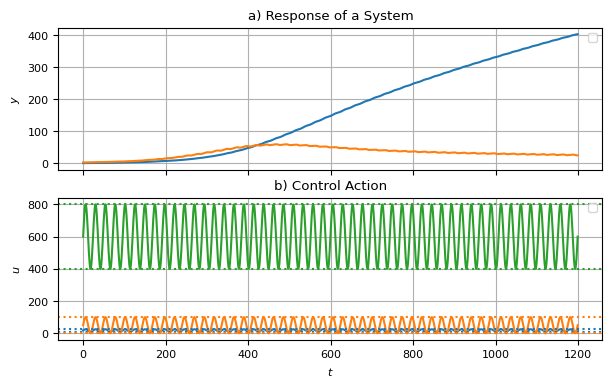

In [63]:
plot_response(t_out, y_out, u_out, u_min=u_min, u_max=u_max)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


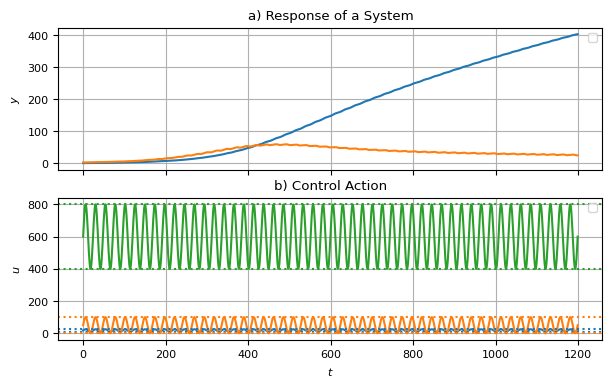

In [64]:
u = partial(gen_u_daily_sine, u_min=u_min, u_max=u_max)

t_out, y_out2, u_out = simulate(
    lettuce_growth_model_ce, u=u, sim_time=sim_time, t_s=60 * 60, x0=x0, c = (0.8, 5e-6, 0.9, 75e-3, 17e-6)
)
plot_response(t_out, y_out2, u_out, u_min=u_min, u_max=u_max)
plt.show()

## One parameter random generating data

In [65]:
x0 = [0.72, 2.7]
u_min = [10, 0, 400]
u_max = [25, 100, 800]
sim_time = 1200
u = partial(gen_u_daily_sine, u_min=u_min, u_max=u_max)

### Change of first constant

In [66]:
# randomly generate list of how_many c values, only one value is random and has changed maximum of max_change
c = (0.8, 5e-6, 0.9, 75e-3, 17e-6)
how_many = 100 # how many values to generate
max_change = 0.1 # maximum change in percentage
which = 0 # which value to change

c_list = []
for i in range(how_many):
    change = [1, 1, 1, 1, 1]
    change[which] = random.uniform(0.9, 1.1)
    c_list.append((c[0]*change[0], c[1]*change[1], c[2]*change[2], c[3]*change[3], c[4]*change[4]))




In [67]:
results_1st = {}

for c in c_list:
    t_out, y_out, u_out = simulate(
        lettuce_growth_model_ce, u=u, sim_time=sim_time, t_s=60 * 60, x0=x0, c = c)
    results_1st[c] = y_out

### Change of second constant

In [68]:
# randomly generate list of how_many c values, only one value is random and has changed maximum of max_change
c = (0.8, 5e-6, 0.9, 75e-3, 17e-6)
how_many = 100 # how many values to generate
max_change = 0.1 # maximum change in percentage
which = 1 # which value to change

c_list = []
for i in range(how_many):
    change = [1, 1, 1, 1, 1]
    change[which] = random.uniform(0.9, 1.1)
    c_list.append((c[0]*change[0], c[1]*change[1], c[2]*change[2], c[3]*change[3], c[4]*change[4]))


In [69]:
results_2nd = {}

for c in c_list:
    t_out, y_out, u_out = simulate(
        lettuce_growth_model_ce, u=u, sim_time=sim_time, t_s=60 * 60, x0=x0, c = c)
    results_2nd[c] = y_out

### Change of third constant

In [70]:
# randomly generate list of how_many c values, only one value is random and has changed maximum of max_change
c = (0.8, 5e-6, 0.9, 75e-3, 17e-6)
how_many = 100 # how many values to generate
max_change = 0.1 # maximum change in percentage
which = 2 # which value to change

c_list = []
for i in range(how_many):
    change = [1, 1, 1, 1, 1]
    change[which] = random.uniform(0.9, 1.1)
    c_list.append((c[0]*change[0], c[1]*change[1], c[2]*change[2], c[3]*change[3], c[4]*change[4]))


In [71]:
results_3rd = {}

for c in c_list:
    t_out, y_out, u_out = simulate(
        lettuce_growth_model_ce, u=u, sim_time=sim_time, t_s=60 * 60, x0=x0, c = c)
    results_3rd[c] = y_out

### Change of fourth constant

In [72]:
# randomly generate list of how_many c values, only one value is random and has changed maximum of max_change
c = (0.8, 5e-6, 0.9, 75e-3, 17e-6)
how_many = 100 # how many values to generate
max_change = 0.1 # maximum change in percentage
which = 3 # which value to change

c_list = []
for i in range(how_many):
    change = [1, 1, 1, 1, 1]
    change[which] = random.uniform(0.9, 1.1)
    c_list.append((c[0]*change[0], c[1]*change[1], c[2]*change[2], c[3]*change[3], c[4]*change[4]))


In [73]:
results_4th = {}

for c in c_list:
    t_out, y_out, u_out = simulate(
        lettuce_growth_model_ce, u=u, sim_time=sim_time, t_s=60 * 60, x0=x0, c = c)
    results_4th[c] = y_out

### Change of fifth constant

In [74]:
# randomly generate list of how_many c values, only one value is random and has changed maximum of max_change
c = (0.8, 5e-6, 0.9, 75e-3, 17e-6)
how_many = 100 # how many values to generate
max_change = 0.1 # maximum change in percentage
which = 4 # which value to change

c_list = []
for i in range(how_many):
    change = [1, 1, 1, 1, 1]
    change[which] = random.uniform(0.9, 1.1)
    c_list.append((c[0]*change[0], c[1]*change[1], c[2]*change[2], c[3]*change[3], c[4]*change[4]))


In [75]:
results_5th = {}

for c in c_list:
    t_out, y_out, u_out = simulate(
        lettuce_growth_model_ce, u=u, sim_time=sim_time, t_s=60 * 60, x0=x0, c = c)
    results_5th[c] = y_out

### Saving data

In [76]:
with open('constant_estimation/data/c_yf_10.pkl', 'wb') as fp:
    pickle.dump(results_1st, fp)
    
with open('constant_estimation/data/c_gr_max_10.pkl', 'wb') as fp:
    pickle.dump(results_2nd, fp)
    
with open('constant_estimation/data/c_k_10.pkl', 'wb') as fp:
    pickle.dump(results_3rd, fp)
    
with open('constant_estimation/data/c_lar_10.pkl', 'wb') as fp:
    pickle.dump(results_4th, fp)
    
with open('constant_estimation/data/c_epsilon_10.pkl', 'wb') as fp:
    pickle.dump(results_5th, fp)

## Every parameter random generating data